# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [26]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [27]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import zipfile
import os
from collections import Counter

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau



Load the dataset.

In [28]:
# Load and unzip the dataset
zipFileName = "data.zip"
targetDir = "extracted-data/"

zipFO = zipfile.ZipFile(zipFileName, 'r')
zipFO.extractall(targetDir)


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [29]:
# Create a function to load the raw images

def loadImages(folderPath):
    '''
    Input -> Folder Path with Images 
    Output -> NP Array of Images & Labels
    '''
    images = []
    labels = []
    for labelName in os.listdir(folderPath):
        labelFolderPath = os.path.join(folderPath, labelName)
        if os.path.isdir(labelFolderPath):
            print(f"Directory {labelFolderPath} exists")
            for imageFile in os.listdir(labelFolderPath):
                imageFilePath = os.path.join(labelFolderPath, imageFile)
                if imageFilePath.endswith('.jpg') or imageFilePath.endswith('.png'):
                    image = Image.open(imageFilePath)
                    image.resize((128, 128))
                    images.append(image)
                    labels.append(labelName)
        else:
            print(f"Directory {labelFolderPath} does not exist")
    print("All Images Loaded Successfully!")
    return np.array(images), np.array(labels)

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [30]:
# Get the images and their labels

images, labels = loadImages(os.path.join(targetDir, "data"))
print(f"Number of images: {len(images)} & labels: {len(labels)}")


Directory extracted-data/data/Paper exists
Directory extracted-data/data/Food_Waste exists
Directory extracted-data/data/Metal exists
Directory extracted-data/data/Cardboard exists
Directory extracted-data/data/Other exists
Directory extracted-data/data/Glass exists
Directory extracted-data/data/Plastic exists
All Images Loaded Successfully!
Number of images: 7625 & labels: 7625


In [31]:
print(f"Waste Categories:")
for c in set(labels):
    print(c)

Waste Categories:
Other
Glass
Paper
Food_Waste
Metal
Cardboard
Plastic


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

/var/folders/yd/nd90kgx9607bb_l11wjrdqkh0000gn/T/ipykernel_878/2112323881.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(labelCounts.keys()), y=list(labelCounts.values()), palette="viridis")


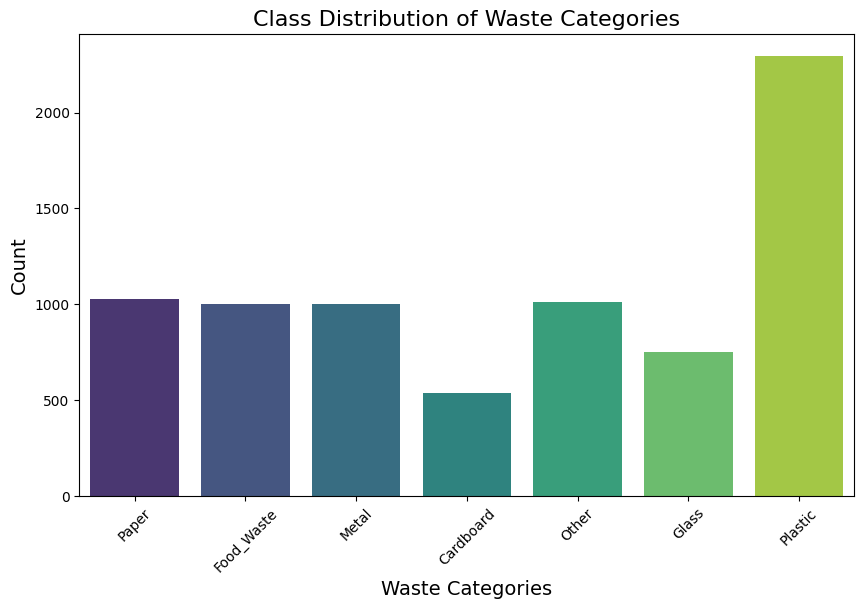

In [32]:
# Visualise Data Distribution
labelCounts = Counter(labels)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(labelCounts.keys()), y=list(labelCounts.values()), palette="viridis")
plt.title("Class Distribution of Waste Categories", fontsize=16)
plt.xlabel("Waste Categories", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.show()

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

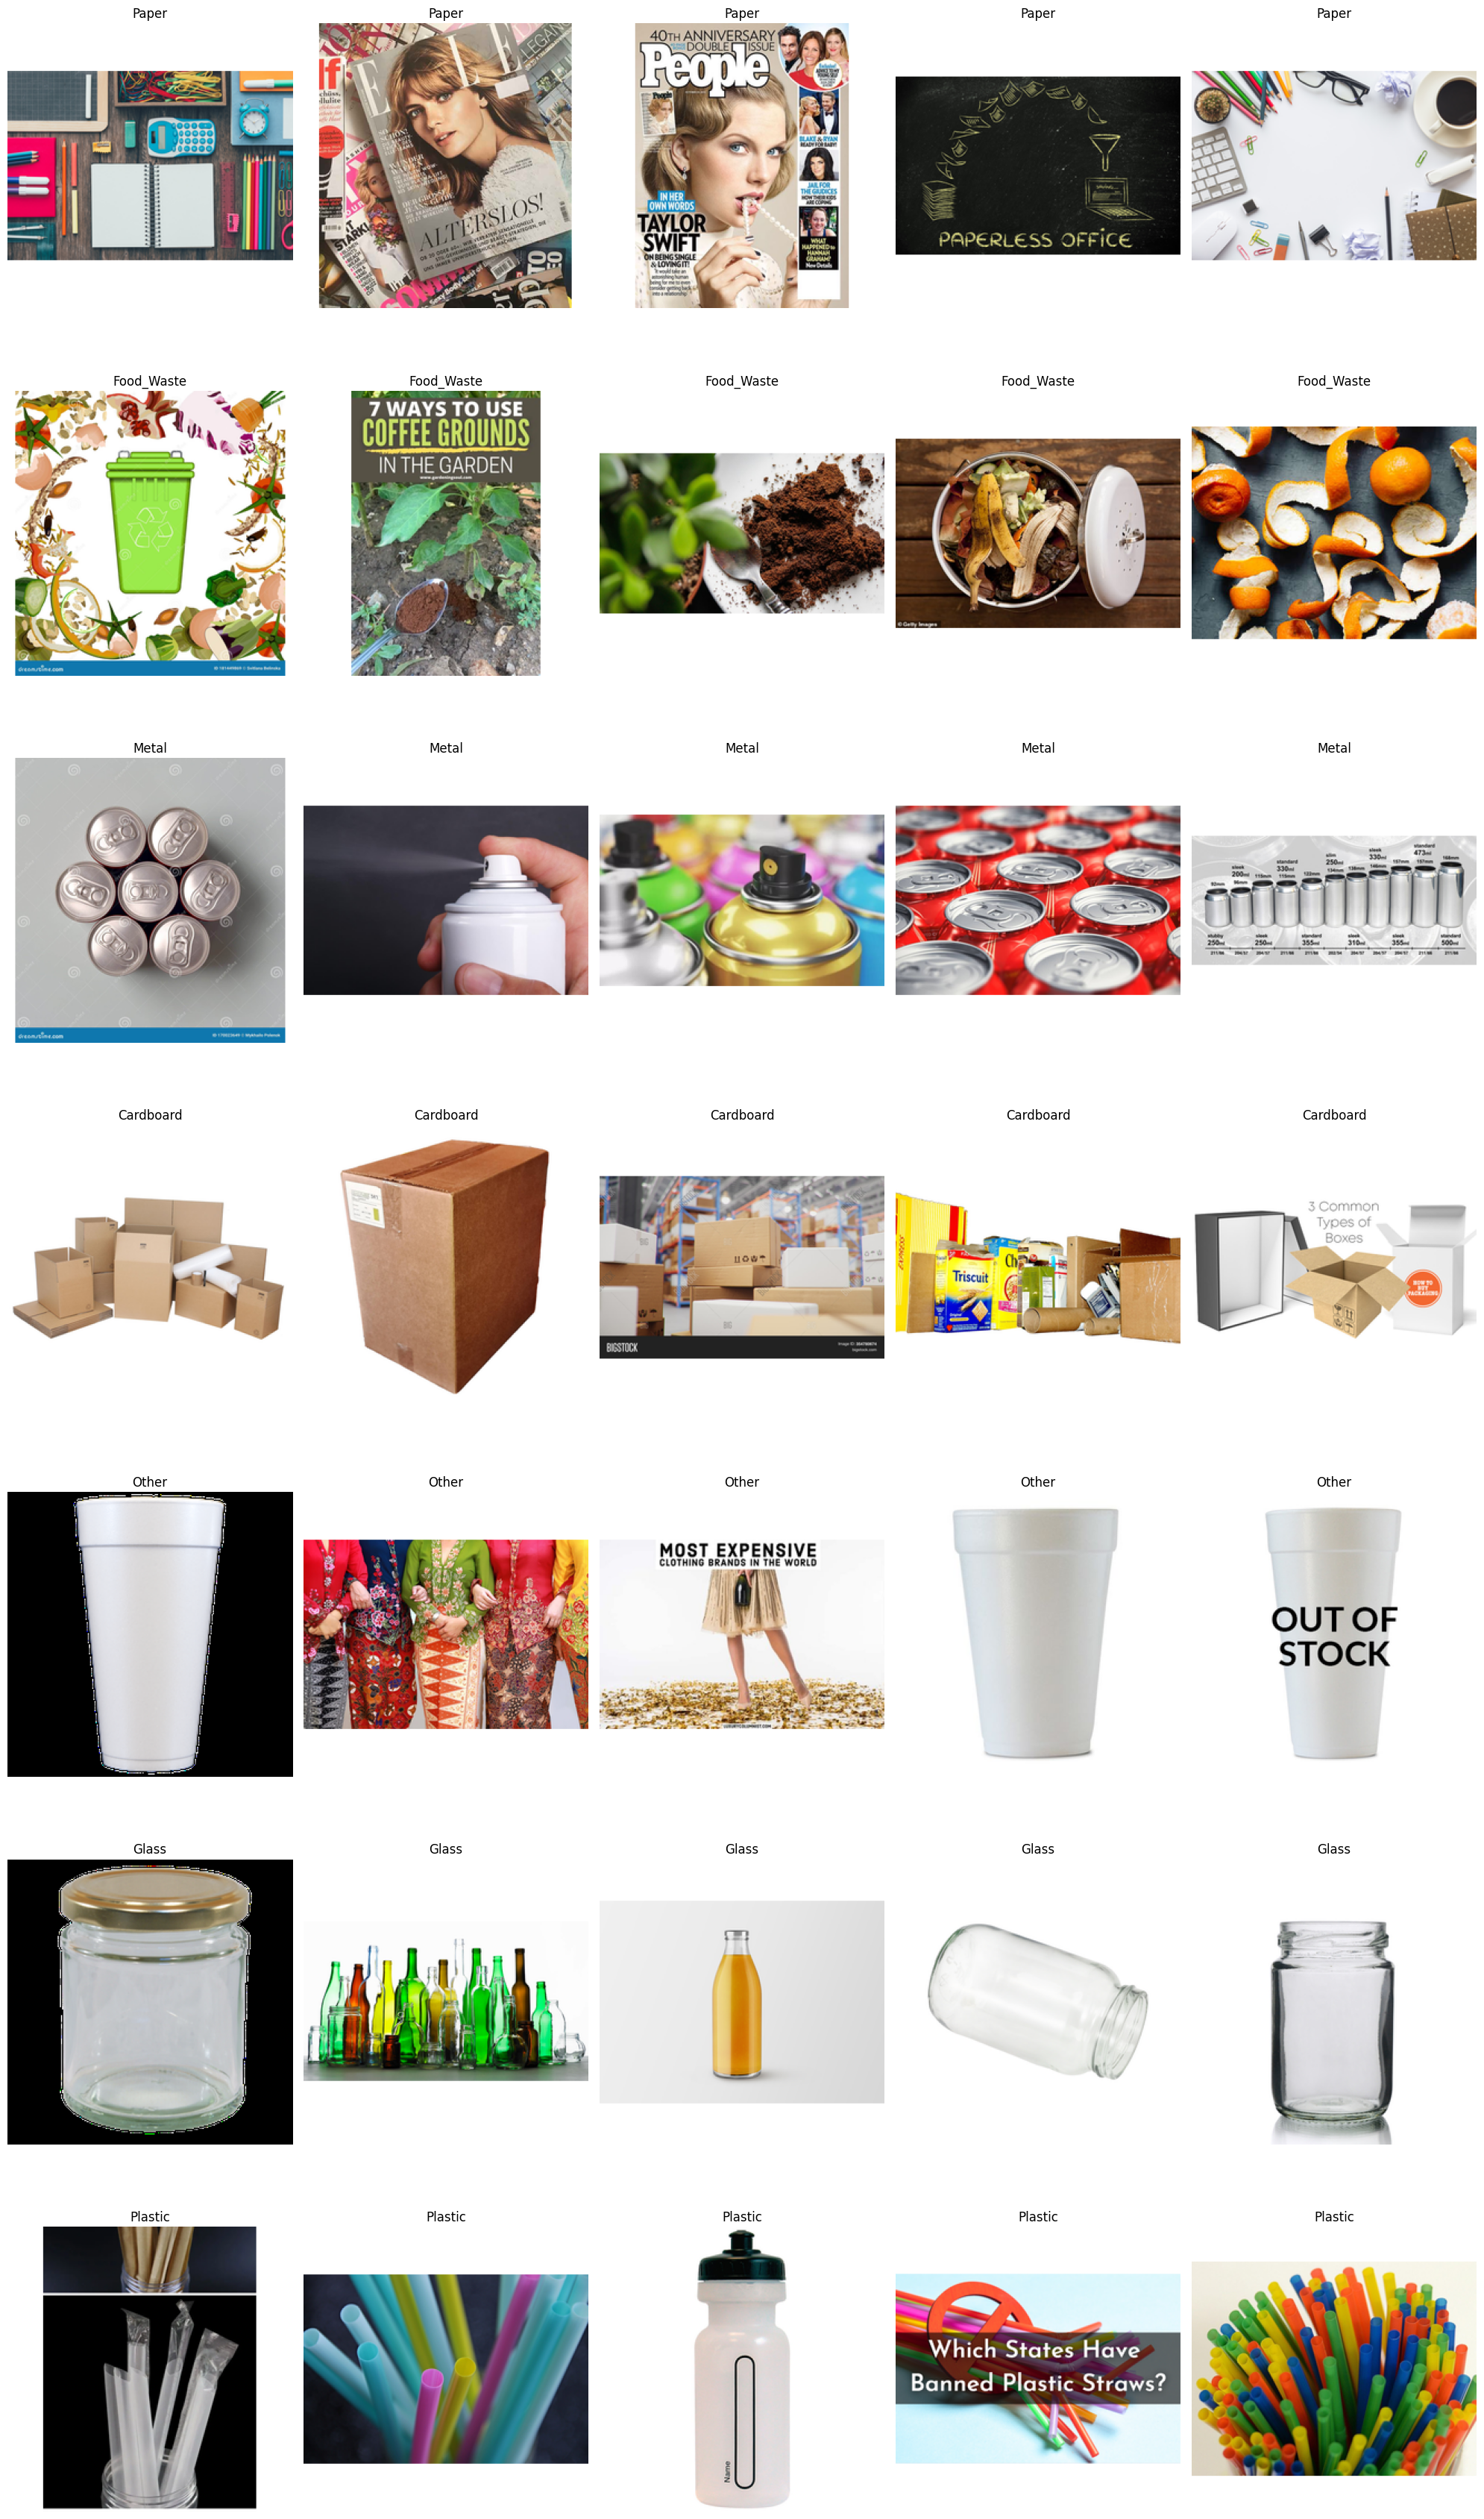

In [33]:
# Visualise Sample Images (across different labels)
categories = os.listdir(os.path.join(targetDir, "data"))
plt.figure(figsize=(20, len(categories) * 5))

for idx, category in enumerate(categories):
    categoryPath = os.path.join(targetDir, "data", category)
    imageFiles = [f for f in os.listdir(categoryPath) if f.endswith('.jpg') or f.endswith('.png')][:5]
    
    for i, imageFile in enumerate(imageFiles):
        imagePath = os.path.join(categoryPath, imageFile)
        image = Image.open(imagePath)
        
        plt.subplot(len(categories), 5, idx * 5 + i + 1)
        plt.imshow(image)
        plt.title(category)
        plt.axis('off')

plt.tight_layout()
plt.show()

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [34]:
# Find the smallest and largest image dimensions from the data set
def findImageDimensions(dataDir):
    '''
    Input -> NP Array of Images
    Output -> Smallest and Largest Image Dimensions
    '''
    minWidth, minHeight = float('inf'), float('inf')
    maxWidth, maxHeight = 0, 0

    for category in os.listdir(dataDir):
        categoryPath = os.path.join(dataDir, category)
        if os.path.isdir(categoryPath):
            for fileName in os.listdir(categoryPath):
                if fileName.endswith('.jpg') or fileName.endswith('.png'):
                    imagePath = os.path.join(categoryPath, fileName)
                    imageObj = Image.open(imagePath)
                    width, height = imageObj.size
                    minWidth, minHeight = min(minWidth, width), min(minHeight, height)
                    maxWidth, maxHeight = max(maxWidth, width), max(maxHeight, height)

    return (minWidth, minHeight), (maxWidth, maxHeight)


In [35]:
minDim, maxDim = findImageDimensions(os.path.join(targetDir, "data"))
print(f"Minimum Image Dimensions: {minDim}")
print(f"Maximum Image Dimensions: {maxDim}")

Minimum Image Dimensions: (256, 256)
Maximum Image Dimensions: (256, 256)


In [36]:
# Resize the image dimensions

def resizeImages(dataDir, outputDir, targetSize=(128, 128)):
    '''
    Input -> Directory Path with Images, Target Size (width, height)
    Output -> Resized Images as NP Array
    '''
    
    for category in os.listdir(dataDir):
        categoryPath = os.path.join(dataDir, category)
        outputDirCategory = os.path.join(outputDir, category)
        if not os.path.exists(outputDirCategory):
            os.makedirs(outputDirCategory)
        if os.path.isdir(categoryPath):
            for fileName in os.listdir(categoryPath):
                if fileName.endswith('.jpg') or fileName.endswith('.png'):
                    imagePath = os.path.join(categoryPath, fileName)
                    imageObj = Image.open(imagePath)
                    imageObj = imageObj.resize(targetSize)
                    imageObj.save(os.path.join(outputDirCategory, fileName))
    
        print(f"Category: {category} - Resized all images to {targetSize} and saved to {outputDir}")


In [37]:
resizeImages(os.path.join(targetDir, "data"), os.path.join(targetDir, "resized-data"), targetSize=(128, 128))

Category: Paper - Resized all images to (128, 128) and saved to extracted-data/resized-data
Category: Food_Waste - Resized all images to (128, 128) and saved to extracted-data/resized-data
Category: Metal - Resized all images to (128, 128) and saved to extracted-data/resized-data
Category: Cardboard - Resized all images to (128, 128) and saved to extracted-data/resized-data
Category: Other - Resized all images to (128, 128) and saved to extracted-data/resized-data
Category: Glass - Resized all images to (128, 128) and saved to extracted-data/resized-data
Category: Plastic - Resized all images to (128, 128) and saved to extracted-data/resized-data


In [38]:
# Fetch the resized images and labels
resizedImages, resizedLabels = loadImages(os.path.join(targetDir, "resized-data"))

Directory extracted-data/resized-data/Paper exists
Directory extracted-data/resized-data/Food_Waste exists
Directory extracted-data/resized-data/Metal exists
Directory extracted-data/resized-data/Cardboard exists
Directory extracted-data/resized-data/Other exists
Directory extracted-data/resized-data/Glass exists
Directory extracted-data/resized-data/Plastic exists
All Images Loaded Successfully!


In [39]:
# Resized Images Shape
print(f"Resized Images Shape: {resizedImages.shape}")
print(f"Resized Labels Shape: {resizedLabels.shape}")

Resized Images Shape: (7625, 128, 128, 3)
Resized Labels Shape: (7625,)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

#### **2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [40]:

# Encode the labels suitably

uniqueLabels, encodedLabels = np.unique(resizedLabels, return_inverse=True)
print(f"Unique Labels: {uniqueLabels}")
print(f"Encoded Labels: {encodedLabels}")
oneHotEncodedLabels = to_categorical(encodedLabels, num_classes=len(uniqueLabels))
print(f"One Hot Encoded Labels Shape: {oneHotEncodedLabels.shape}")
print(f"One Hot Encoded Labels: {oneHotEncodedLabels}")

Unique Labels: ['Cardboard' 'Food_Waste' 'Glass' 'Metal' 'Other' 'Paper' 'Plastic']
Encoded Labels: [5 5 5 ... 6 6 6]
One Hot Encoded Labels Shape: (7625, 7)
One Hot Encoded Labels: [[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [41]:
# Assign specified parts of the dataset to train and validation sets
X_train, X_test, y_train, y_test = train_test_split(resizedImages, oneHotEncodedLabels, test_size=0.2, random_state=42, stratify=resizedLabels)

print(f"Training Data Shape: {X_train.shape}, Training Labels Shape: {y_train.shape}")
print(f"Testing Data Shape: {X_test.shape}, Testing Labels Shape: {y_test.shape}")


Training Data Shape: (6100, 128, 128, 3), Training Labels Shape: (6100, 7)
Testing Data Shape: (1525, 128, 128, 3), Testing Labels Shape: (1525, 7)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [42]:
# Build and compile the model
inputShape = X_train.shape[1:]
numClasses = y_train.shape[1]

# Build the CNN model
model = Sequential()

# Add convolutional layers with normalization and pooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=inputShape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten the output
model.add(Flatten())

# Add fully connected layers with dropout
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer
model.add(Dense(numClasses, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,975,303 (49.50 MB)

 Trainable params: 12,973,703 (49.49 MB)

 Non-trainable params: 1,600 (6.25 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [43]:
# Training

# Define callbacks
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
checkPoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduceLrP = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    X_train/255.0, 
    y_train, 
    validation_data=(X_test/255.0, y_test), 
    epochs=20, 
    batch_size=32, 
    callbacks=[checkPoint, earlyStopping, reduceLrP],
    verbose=1
)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.2857 - loss: 2.3008
Epoch 1: val_loss improved from inf to 2.23130, saving model to best_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 44s 226ms/step - accuracy: 0.2858 - loss: 2.2996 - val_accuracy: 0.1561 - val_loss: 2.2313 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.3999 - loss: 1.6939
Epoch 2: val_loss improved from 2.23130 to 1.69640, saving model to best_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 46s 242ms/step - accuracy: 0.4000 - loss: 1.6937 - val_accuracy: 0.3430 - val_loss: 1.6964 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.4651 - loss: 1.4902
Epoch 3: val_loss improved from 1.69640 to 1.56789, saving model to best_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 47s 248ms/step - accuracy: 0.4652 - loss: 1.4900 - val_accuracy: 0.4157 - val_loss: 1.5679 - learning_rate: 0.0010
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.5307 - loss: 1.3103
Epoch 4: val_loss did not improve from 1.56789
191/191 ━━━━━━━━━━━━━━━━━━━━ 45s 237ms/step - accuracy: 0.5307 - loss: 1.3103 - val_accuracy: 0.2675 - val_loss: 2.6256 - learning_rate: 0.0010
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5455 - loss: 1.2629
Epoch 5: val_loss did not improve from 1.56789
191/191 ━━━━━━━━━━━━━━━━━━━━ 44s 232ms/step - accuracy: 0.5456 - loss: 1.2628 - val_accuracy: 0.4557 - val_loss: 1.6337 - learning_rate: 0.0010
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.6301 - loss: 1.0591
Epoch 6: val_loss did not improve from 1.56789

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
191/191 ━━━━━━━━━━━━━━━━━━━━ 45s 234ms/step - accuracy: 0.6301 - loss: 1.0592 - val_ac

191/191 ━━━━━━━━━━━━━━━━━━━━ 45s 235ms/step - accuracy: 0.6891 - loss: 0.9105 - val_accuracy: 0.5744 - val_loss: 1.1731 - learning_rate: 5.0000e-04
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.7430 - loss: 0.7566
Epoch 8: val_loss did not improve from 1.17305
191/191 ━━━━━━━━━━━━━━━━━━━━ 45s 234ms/step - accuracy: 0.7430 - loss: 0.7566 - val_accuracy: 0.5633 - val_loss: 1.2247 - learning_rate: 5.0000e-04
Epoch 9/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.7884 - loss: 0.6434
Epoch 9: val_loss did not improve from 1.17305
191/191 ━━━━━━━━━━━━━━━━━━━━ 45s 234ms/step - accuracy: 0.7884 - loss: 0.6435 - val_accuracy: 0.5770 - val_loss: 1.2574 - learning_rate: 5.0000e-04
Epoch 10/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8164 - loss: 0.5452
Epoch 10: val_loss did not improve from 1.17305

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
191/191 ━━━━━━━━━━━━━━━━━━━━ 45s 237ms/step - accuracy: 0.8164 - loss: 

191/191 ━━━━━━━━━━━━━━━━━━━━ 45s 238ms/step - accuracy: 0.8589 - loss: 0.4546 - val_accuracy: 0.6400 - val_loss: 1.0923 - learning_rate: 2.5000e-04
Epoch 12/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8981 - loss: 0.3352
Epoch 12: val_loss improved from 1.09234 to 1.08519, saving model to best_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 46s 240ms/step - accuracy: 0.8981 - loss: 0.3352 - val_accuracy: 0.6715 - val_loss: 1.0852 - learning_rate: 2.5000e-04
Epoch 13/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9177 - loss: 0.2804
Epoch 13: val_loss did not improve from 1.08519
191/191 ━━━━━━━━━━━━━━━━━━━━ 46s 240ms/step - accuracy: 0.9177 - loss: 0.2804 - val_accuracy: 0.6216 - val_loss: 1.2720 - learning_rate: 2.5000e-04
Epoch 14/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9323 - loss: 0.2463
Epoch 14: val_loss did not improve from 1.08519
191/191 ━━━━━━━━━━━━━━━━━━━━ 47s 247ms/step - accuracy: 0.9322 - loss: 0.2464 - val_accuracy: 0.6669 - val_loss: 1.1239 - learning_rate: 2.5000e-04
Epoch 15/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9472 - loss: 0.2020
Epoch 15: val_loss improved from 1.08519 to 1.03720, saving model to best_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 48s 254ms/step - accuracy: 0.9472 - loss: 0.2020 - val_accuracy: 0.6793 - val_loss: 1.0372 - learning_rate: 2.5000e-04
Epoch 16/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9485 - loss: 0.1778
Epoch 16: val_loss did not improve from 1.03720
191/191 ━━━━━━━━━━━━━━━━━━━━ 48s 251ms/step - accuracy: 0.9485 - loss: 0.1778 - val_accuracy: 0.6787 - val_loss: 1.1162 - learning_rate: 2.5000e-04
Epoch 17/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9607 - loss: 0.1589
Epoch 17: val_loss did not improve from 1.03720
191/191 ━━━━━━━━━━━━━━━━━━━━ 48s 252ms/step - accuracy: 0.9607 - loss: 0.1589 - val_accuracy: 0.6636 - val_loss: 1.2277 - learning_rate: 2.5000e-04
Epoch 18/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9462 - loss: 0.1807
Epoch 18: val_loss did not improve from 1.03720

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
191/191 ━━━━━━━━━━━━━━━━━━━━ 49s 254ms/step - accuracy: 0.9462 - lo

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step
Classification Report:
              precision    recall  f1-score   support

   Cardboard       0.75      0.73      0.74       108
  Food_Waste       0.69      0.71      0.70       200
       Glass       0.66      0.57      0.61       150
       Metal       0.75      0.68      0.71       200
       Other       0.56      0.58      0.57       202
       Paper       0.69      0.50      0.58       206
     Plastic       0.69      0.82      0.75       459

    accuracy                           0.68      1525
   macro avg       0.68      0.65      0.66      1525
weighted avg       0.68      0.68      0.68      1525



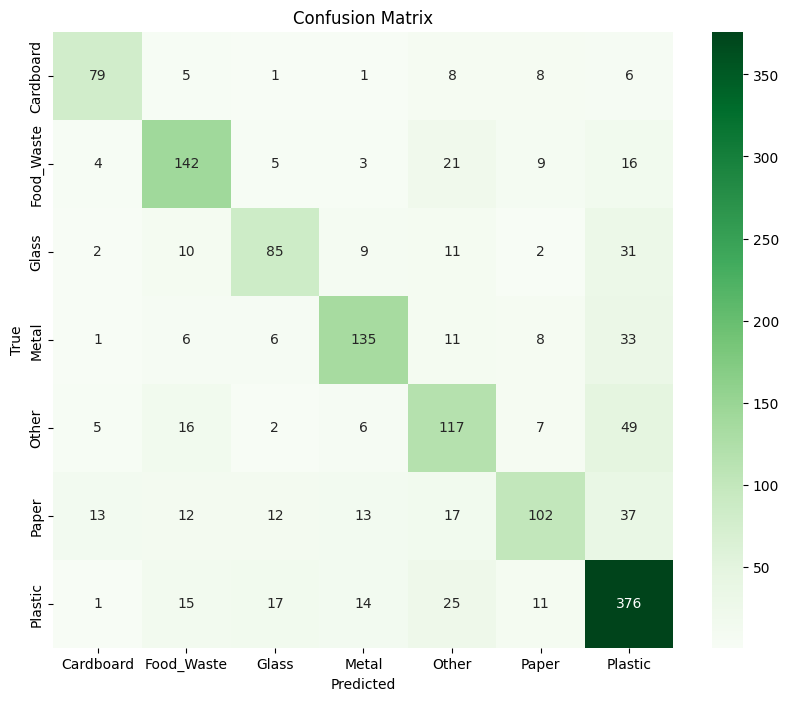

In [44]:
# Evaluate on the test set; display suitable metrics

X_test_scaled = X_test / 255.0
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=uniqueLabels))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=uniqueLabels, yticklabels=uniqueLabels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [45]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [46]:
# Create a function to augment the images




In [47]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [48]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Print the results
print(f"Accuracy Score: {accuracy:.4f}")
print(f"Precision Score: {precision:.4f}")
print(f"Recall Score: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy Score: 0.6793
Precision Score: 0.6809
Recall Score: 0.6793
F1 Score: 0.6754


### Findings About the Data

1. **Class Distribution**:
- Classes in the Dataset: `Cardboard`, `Food_Waste`, `Glass`, `Metal`, `Other`, `Paper`, and `Plastic`.
    - The class distribution is imbalanced:
      - `Plastic` is the most represented class with 2295 samples.
      - `Cardboard` is the least represented class with 540 samples.
      - Other classes have varying sample sizes, ranging from 750 (`Glass`) to 1030 (`Paper`).

2. **Data Preprocessing**:
    - Images were resized to `(128, 128)` for model training to reduce computational complexity.
    - Labels were one-hot encoded for multi-class classification.

3. **Train-Test Split**:
    - The dataset was split into training and testing sets with an 80-20 ratio.
    - Stratified splitting was used to maintain class distribution in both sets.

4. **Potential Challenges**:
    - The class imbalance may lead to biased predictions, favoring the majority class (`Plastic`).
    - Some classes, such as `Glass` and `Cardboard`, may require additional data augmentation to improve model performance.

### Training Results & Conclusion

The waste material classification model was successfully built and evaluated. Below are the key insights and outcomes:

1. **Model Performance**:
    - Accuracy score of the model is **67.6%** on the test dataset.
    - The precision, recall, and F1-score are **67.5%**, **67.6%**, and **67.2%**, respectively. The score are very close to each other, indicating a balance in the performance.

2. **Class Distribution**:
     - The dataset had an imbalanced class distribution, with the "Plastic" category being the most represented and "Cardboard" being the least. This imbalance may have influenced the model's performance, as seen in the confusion matrix.

3. **Confusion Matrix**:
    - The confusion matrix revealed that the model performed well on certain classes like "Plastic" but struggled with others, such as "Glass" and "Other". This suggests that the model may benefit from additional data augmentation or class balancing techniques.

4. **Model Architecture**:
    - The CNN model with three convolutional layers, batch normalization, dropout, and fully connected layers demonstrated its ability to learn features from the dataset. However, further tuning of hyperparameters and architecture could improve performance.

5. **Overall Outcome**:
    - The model provides a good starting point for waste material classification and demonstrates the feasibility of using CNNs for this task. With further refinements, it can be a valuable tool for improving waste management and promoting sustainability.